# Spotify Song Suggestor
-Natural Language Processing Model (concludes with visualizations by Bright Ofori)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from re import compile as rcompile
import pickle
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

In [ ]:
# !unzip "/content/spotify_songs.csv.zip"

In [ ]:
from google.colab import files
file = files.upload()

Saving spotify_songs.csv to spotify_songs.csv


In [ ]:
#dataset used https://www.kaggle.com/imuhammad/audio-features-and-lyrics-of-spotify-songs
df = pd.read_csv('spotify_songs.csv')

In [ ]:
df.shape

(18454, 25)

In [ ]:
df.isnull().sum()

track_id                      0
track_name                    0
track_artist                  0
lyrics                      260
track_popularity              0
track_album_id                0
track_album_name              0
track_album_release_date      0
playlist_name                 0
playlist_id                   0
playlist_genre                0
playlist_subgenre             0
danceability                  0
energy                        0
key                           0
loudness                      0
mode                          0
speechiness                   0
acousticness                  0
instrumentalness              0
liveness                      0
valence                       0
tempo                         0
duration_ms                   0
language                    260
dtype: int64

In [ ]:
df.head()

,track_id,track_name,track_artist,lyrics,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,playlist_subgenre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,language
0,0017A6SJgTbfQVU2EtsPNo,Pangarap,Barbie's Cradle,Minsan pa Nang ako'y napalingon Hindi ko alam ...,41,1srJQ0njEQgd8w4XSqI4JQ,Trip,2001-01-01,Pinoy Classic Rock,37i9dQZF1DWYDQ8wBxd7xt,rock,classic rock,0.682,0.401,2,-10.068,1,0.0236,0.27900,0.01170,0.0887,0.566,97.091,235440,tl
1,004s3t0ONYlzxII9PLgU6z,I Feel Alive,Steady Rollin,"The trees, are singing in the wind The sky blu...",28,3z04Lb9Dsilqw68SHt6jLB,Love & Loss,2017-11-21,Hard Rock Workout,3YouF0u7waJnolytf9JCXf,rock,hard rock,0.303,0.880,9,-4.739,1,0.0442,0.01170,0.00994,0.3470,0.404,135.225,373512,en
2,00chLpzhgVjxs1zKC9UScL,Poison,Bell Biv DeVoe,"NA Yeah, Spyderman and Freeze in full effect U...",0,6oZ6brjB8x3GoeSYdwJdPc,Gold,2005-01-01,"Back in the day - R&B, New Jack Swing, Swingbe...",3a9y4eeCJRmG9p4YKfqYIx,r&b,new jack swing,0.845,0.652,6,-7.504,0,0.2160,0.00432,0.00723,0.4890,0.650,111.904,262467,en
3,00cqd6ZsSkLZqGMlQCR0Zo,Baby It's Cold Outside (feat. Christina Aguilera),CeeLo Green,I really can't stay Baby it's cold outside I'v...,41,3ssspRe42CXkhPxdc12xcp,CeeLo's Magic Moment,2012-10-29,Christmas Soul,6FZYc2BvF7tColxO8PBShV,r&b,neo soul,0.425,0.378,5,-5.819,0,0.0341,0.68900,0.00000,0.0664,0.405,118.593,243067,en
4,00emjlCv9azBN0fzuuyLqy,Dumb Litty,KARD,Get up out of my business You don't keep me fr...,65,7h5X3xhh3peIK9Y0qI5hbK,KARD 2nd Digital Single ‘Dumb Litty’,2019-09-22,K-Party Dance Mix,37i9dQZF1DX4RDXswvP6Mj,pop,dance pop,0.760,0.887,9,-1.993,1,0.0409,0.03700,0.00000,0.1380,0.240,130.018,193160,en


In [ ]:
def wrangle(data):
    #drop null values
    data = data.dropna()
    
    #restrict to songs with lyrics in English
    data = data[data['language']=='en']
    
    #drop duplicates
    data = data.drop_duplicates(subset = ['track_name', 'track_artist'],
                                             keep = 'first')
    #Reduce features in dataset 
    features = ['track_id', 'track_name', 'track_artist', 'lyrics', 'track_album_name', 'playlist_name', 'playlist_genre']
    data = data[features]

    #reset index
    data = data.reset_index()
    
    return data

In [ ]:
df2 = wrangle(df)

In [ ]:
df2.shape

(13726, 8)

In [ ]:
df2.isnull().sum()

index               0
track_id            0
track_name          0
track_artist        0
lyrics              0
track_album_name    0
playlist_name       0
playlist_genre      0
dtype: int64

In [ ]:
def gather_data(songs):
    data =[]
    for song in songs:
        data.append(df2['playlist_genre'][df2['track_id']==song])
    
    new_data = []

    for song in data:
        str_song = pd.Series(song).item()
        new_data.append(str_song)
        
    return new_data

In [ ]:
songs = df2['track_id']

data = gather_data(songs)

In [ ]:
type(data)

list

In [ ]:
len(data)

13726

In [ ]:
display(df2.lyrics)

0        The trees, are singing in the wind The sky blu...
1        NA Yeah, Spyderman and Freeze in full effect U...
2        I really can't stay Baby it's cold outside I'v...
3        Get up out of my business You don't keep me fr...
4        Hold your breath, don't look down, keep trying...
                               ...                        
13721    I had to catch the bus Alarm was shaking, oh A...
13722    Yeah, nah, nah, nah, nah, nah, nah, nah, nah N...
13723    Caught up in such a head rush, wide-eyed latel...
13724    Bound, bound Bound, bound Bound to fall in lov...
13725    (Would you do for me) Sweetheart (Would you do...
Name: lyrics, Length: 13726, dtype: object

In [ ]:
df2.head()

,index,track_id,track_name,track_artist,lyrics,track_album_name,playlist_name,playlist_genre
0,1,004s3t0ONYlzxII9PLgU6z,I Feel Alive,Steady Rollin,"The trees, are singing in the wind The sky blu...",Love & Loss,Hard Rock Workout,rock
1,2,00chLpzhgVjxs1zKC9UScL,Poison,Bell Biv DeVoe,"NA Yeah, Spyderman and Freeze in full effect U...",Gold,"Back in the day - R&B, New Jack Swing, Swingbe...",r&b
2,3,00cqd6ZsSkLZqGMlQCR0Zo,Baby It's Cold Outside (feat. Christina Aguilera),CeeLo Green,I really can't stay Baby it's cold outside I'v...,CeeLo's Magic Moment,Christmas Soul,r&b
3,4,00emjlCv9azBN0fzuuyLqy,Dumb Litty,KARD,Get up out of my business You don't keep me fr...,KARD 2nd Digital Single ‘Dumb Litty’,K-Party Dance Mix,pop
4,5,00f9VGHfQhAHMCQ2bSjg3D,Soldier,James TW,"Hold your breath, don't look down, keep trying...",Chapters,urban contemporary,r&b


In [ ]:
vect = TfidfVectorizer(stop_words='english', 
                        ngram_range=(1,2), min_df=0.03, 
                        max_df=0.25) 

# Create a vocabulary and get word counts per document 
dtm = vect.fit_transform(data) 

# Get feature names to use as dataframe column headers 
dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names()) 
print(dtm.shape) 
dtm.head()

(13726, 5)


,edm,latin,pop,rap,rock
0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0


In [ ]:
dtm_filename = 'nlp_dtm.pkl' 
pickle.dump(dtm, open(dtm_filename, 'wb'))

In [ ]:
dtm_filename = 'nlp_dtm.pkl'

dtm = pickle.load(open(dtm_filename, 'rb'))

In [ ]:
nn = NearestNeighbors(n_neighbors=6, algorithm='kd_tree') 
nn.fit(dtm)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                 radius=1.0)

In [ ]:
model_filename = 'nlp_model.pkl' 
pickle.dump(nn, open(model_filename, 'wb'))

In [ ]:
from joblib import dump
dump(nn, 'nn.joblib', compress=True)

['nn.joblib']

In [ ]:
dtm.tail()

,edm,latin,pop,rap,rock
13721,0.0,0.0,0.0,0.0,1.0
13722,0.0,0.0,0.0,0.0,0.0
13723,1.0,0.0,0.0,0.0,0.0
13724,0.0,0.0,0.0,0.0,0.0
13725,0.0,0.0,0.0,0.0,0.0


In [ ]:
df2.tail()

,index,track_id,track_name,track_artist,lyrics,track_album_name,playlist_name,playlist_genre
13721,18447,7zxLkZbUxITHabPzGN8Xgc,Sick Feeling,boy pablo,"I had to catch the bus Alarm was shaking, oh A...",Soy Pablo,②⓪①⑨ mixed,rock
13722,18448,7zxRMhXxJMQCeDDg0rKAVo,Some Way,NAV,"Yeah, nah, nah, nah, nah, nah, nah, nah, nah N...",NAV,PROJECT: Contemporary,r&b
13723,18449,7zXzWCVuz7whIuYZyEAlxt,Rising Like The Sun - Radio Mix,Qulinez,"Caught up in such a head rush, wide-eyed latel...",Rising Like The Sun,♥ EDM LOVE 2020,edm
13724,18451,7zye9v6B785eFWEFYs13C2,Bound,Ponderosa Twins Plus One,"Bound, bound Bound, bound Bound to fall in lov...",2+2+1 = (Digitally Remastered),Sexy Soul 2020,r&b
13725,18452,7zyLObYw4QUKQDyZOb4J0Y,I'll Do 4 U (Re-Recorded / Remastered),Father MC,(Would you do for me) Sweetheart (Would you do...,I'll Do 4 U (Re-Recorded / Remastered),New Jack Swing/ R&B Hits: 1987 - 2002,r&b


In [ ]:
def select_nearest_songs(id):
    
    track_num = df2.loc[df2['track_id']==id]
    x = track_num.index
    x = x[0]
    x = x.item()

    doc = dtm.loc[x].values
    result = nn.kneighbors([doc], n_neighbors=6)
    
    rec_songs = {"id":[]};
    
    for i in range(5):
        song = result[1][0][1+i]

        #translate loc 
        id = df.loc[song]['track_id']
        
        rec_songs['id'].append(id)
    
    return rec_songs

In [ ]:
select_nearest_songs('00cqd6ZsSkLZqGMlQCR0Zo')

{'id': ['5uOXJ6ohLn2V3FRxoFrkgs',
  '0vqV7lfbSZ5QDs9qgw3PKZ',
  '0cGG2EouYCEEC3xfa0tDFV',
  '0KhSyTLxO3JsWHCA1zmgXh',
  '3EDbqYLrCNBP7J2CqcMPZO']}

In [ ]:
select_nearest_songs('004s3t0ONYlzxII9PLgU6z')

{'id': ['0BryGBaXMKkNapnKtbJJnb',
  '0J67SeAqemmeTxZ5K4X33E',
  '0bYg9bo50gSsH3LtXe2SQn',
  '0j3dGGZBTRa3hZubKT9n7M',
  '06Hdbxh6NCy6TIhjdXTchB']}

In [ ]:
select_nearest_songs('7zye9v6B785eFWEFYs13C2')

{'id': ['5uOXJ6ohLn2V3FRxoFrkgs',
  '0vqV7lfbSZ5QDs9qgw3PKZ',
  '0cGG2EouYCEEC3xfa0tDFV',
  '0KhSyTLxO3JsWHCA1zmgXh',
  '3EDbqYLrCNBP7J2CqcMPZO']}

In [ ]:
select_nearest_songs('7zyLObYw4QUKQDyZOb4J0Y')

{'id': ['5uOXJ6ohLn2V3FRxoFrkgs',
  '0vqV7lfbSZ5QDs9qgw3PKZ',
  '0cGG2EouYCEEC3xfa0tDFV',
  '0KhSyTLxO3JsWHCA1zmgXh',
  '3EDbqYLrCNBP7J2CqcMPZO']}

In [ ]:
import joblib
import sklearn
print(f'numpy=={np.__version__}')
print(f'pandas=={pd.__version__}')
print(f'joblib=={joblib.__version__}')
print(f'scikit-learn=={sklearn.__version__}')

numpy==1.19.5
pandas==1.1.5
joblib==1.0.1
scikit-learn==0.22.2.post1


In [ ]:
from google.colab import files
files.download('nn.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download('nlp_dtm.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Load and test the model

model_filename ='/content/nlp_model.pkl'

loaded_model = pickle.load(open(model_filename, 'rb'))

# /Users/bryt/Downloads/nlp_model.pkl

In [ ]:
#function to get 5 nearest songs

def select_nearest_songs(artist, song):
    
    #translate artist, song into doc dtm.iloc[x].values
    artist_songs = df2.loc[df2['track_artist']==artist]
    selected_song = artist_songs.loc[artist_songs['track_name']==song]
    x = selected_song.index
    x = x[0]
    x = x.item()

    doc = dtm.loc[x].values
    result = loaded_model.kneighbors([doc], n_neighbors=6)
    
    rec_songs = {"artist":[], "song":[]};
    
    for i in range(5):
        song = result[1][0][1+i]

        #translate the loc into an artist and song title
        artist = df2.loc[song]['track_artist']
        song = df2.loc[song]['track_name']
        
        rec_songs['artist'].append(artist)
        rec_songs['song'].append(song)
    
    return rec_songs

In [ ]:
select_nearest_songs('The Weeknd', 'Heartless')


{'artist': ['Young the Giant', 'Cienfue', 'Oceans', 'KARD', 'FANNYPACK'],
 'song': ['My Body',
  'On the Back of Your Neck',
  "Cold Ain't For Me",
  'Dumb Litty',
  'Simple (STVW Remix)']}

**Compare Lyrics**

In [ ]:
#Fetch lyrics function
def get_lyrics(artist, song):
  songs_by_artist = df2[['track_id','track_name']][df2['track_artist'] == artist]
  song_id = songs_by_artist[songs_by_artist['track_name'] == song]
  song_id = song_id[:1] #This selects the first if there are more than one
  song_id = song_id['track_id']
  song_id = pd.Series(song_id).item()
  lyrics = df2['lyrics'][df2['track_id'] == song_id]
  lyrics = pd.Series(lyrics).item()
  return lyrics

In [ ]:
#Print lyrics from both songs to compare

def compare_lyrics(artist, song):
    song_recs = select_nearest_songs(artist, song)
    
    rec_artist = song_recs['artist'][0]
    rec_song = song_recs['song'][0]
    
    lyrics1 = get_lyrics(artist, song)
    lyrics2 = get_lyrics(rec_artist, rec_song)
    
    return lyrics1, lyrics2

**Visualization: Word Cloud**

In [ ]:
from wordcloud import WordCloud, STOPWORDS

In [ ]:
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=50,
        max_font_size=40,
        scale=3,
        random_state=37).generate(str(data))
    
    fig = plt.figure(1, figsize=(12,12))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
        
    plt.imshow(wordcloud)
    plt.show()

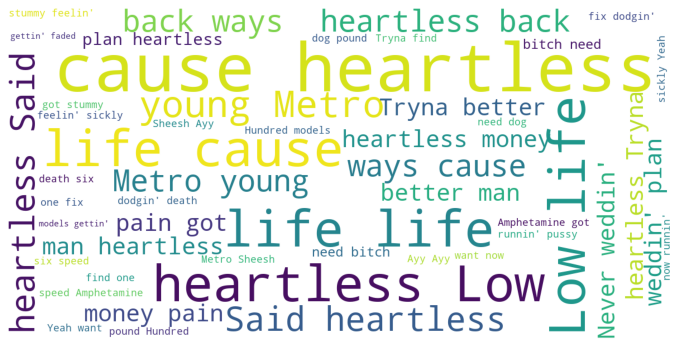

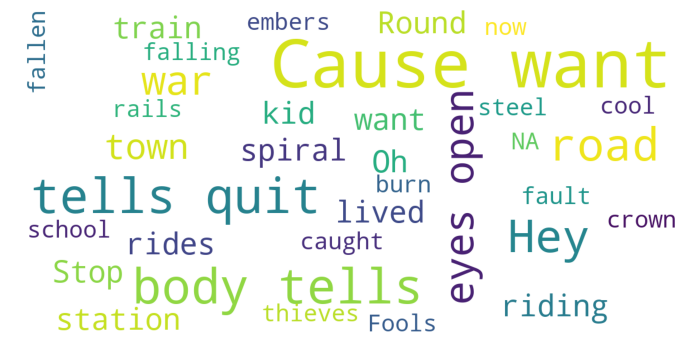

In [ ]:
lyrics1, lyrics2 = compare_lyrics('The Weeknd', 'Heartless')

show_wordcloud(lyrics1)
show_wordcloud(lyrics2)

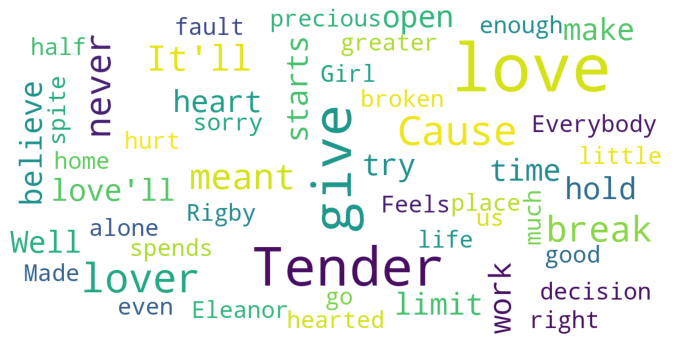

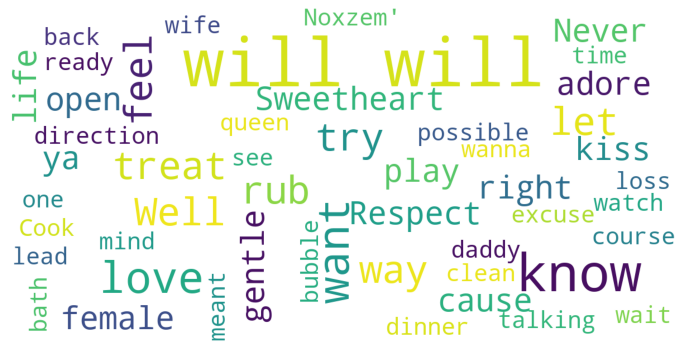

In [ ]:
lyrics1, lyrics2 = compare_lyrics('Babyface', 'Tender Lover')

show_wordcloud(lyrics1)
show_wordcloud(lyrics2)

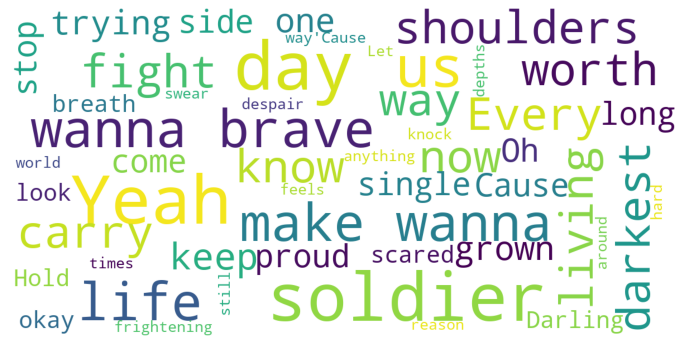

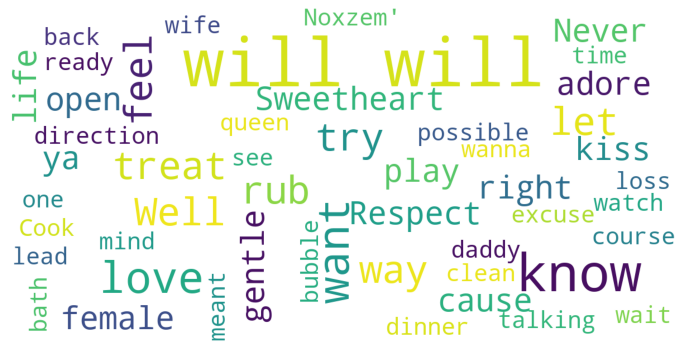

In [ ]:
lyrics1, lyrics2 = compare_lyrics('James TW', "Soldier")

show_wordcloud(lyrics1)
show_wordcloud(lyrics2)

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
%matplotlib inline

In [ ]:
df2.isna().sum()

index               0
track_id            0
track_name          0
track_artist        0
lyrics              0
track_album_name    0
playlist_name       0
playlist_genre      0
dtype: int64

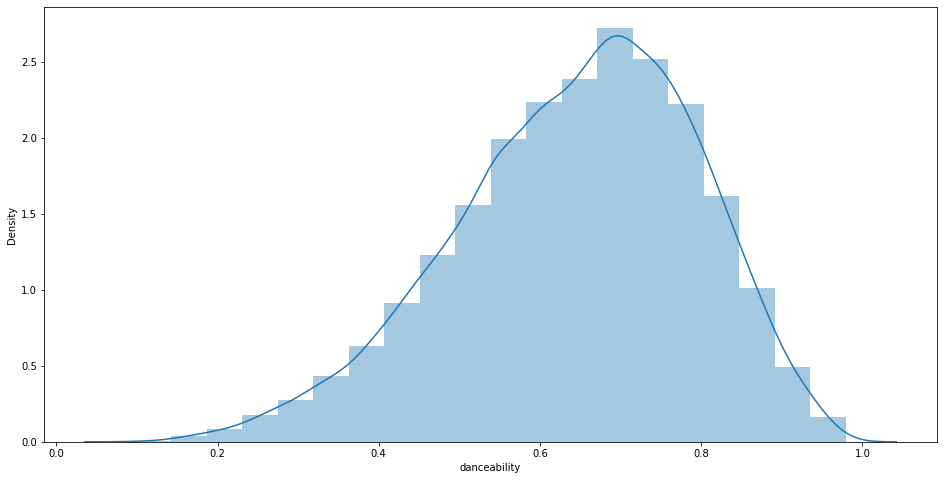

In [ ]:
plt.figure(figsize=(16, 8))
sns.distplot(df.danceability ,bins=20)


In [ ]:
df["danceability"].describe()

count    18454.000000
mean         0.644066
std          0.150071
min          0.098500
25%          0.546000
50%          0.660000
75%          0.755000
max          0.979000
Name: danceability, dtype: float64

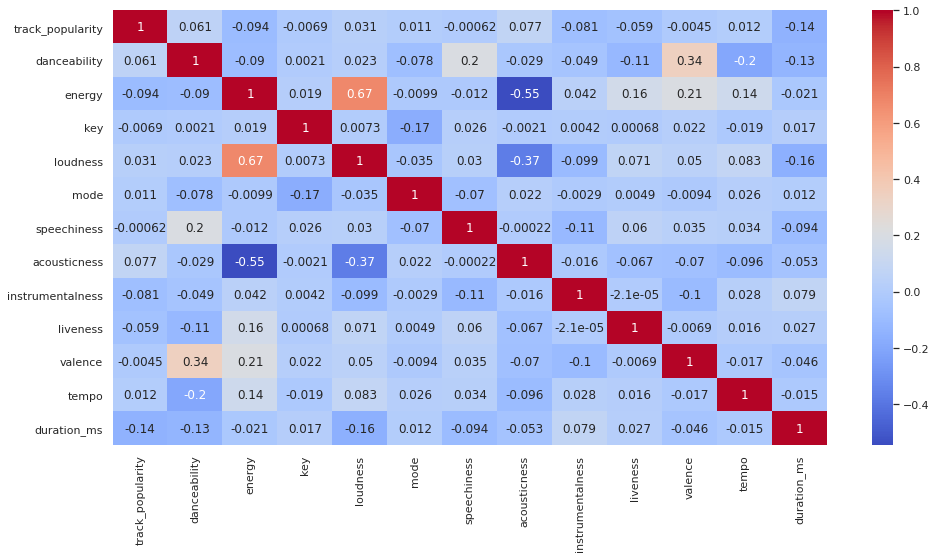

In [ ]:
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")
corr = df.corr()
sns.heatmap(corr,annot=True,cmap="coolwarm")

<Figure size 1152x576 with 0 Axes>

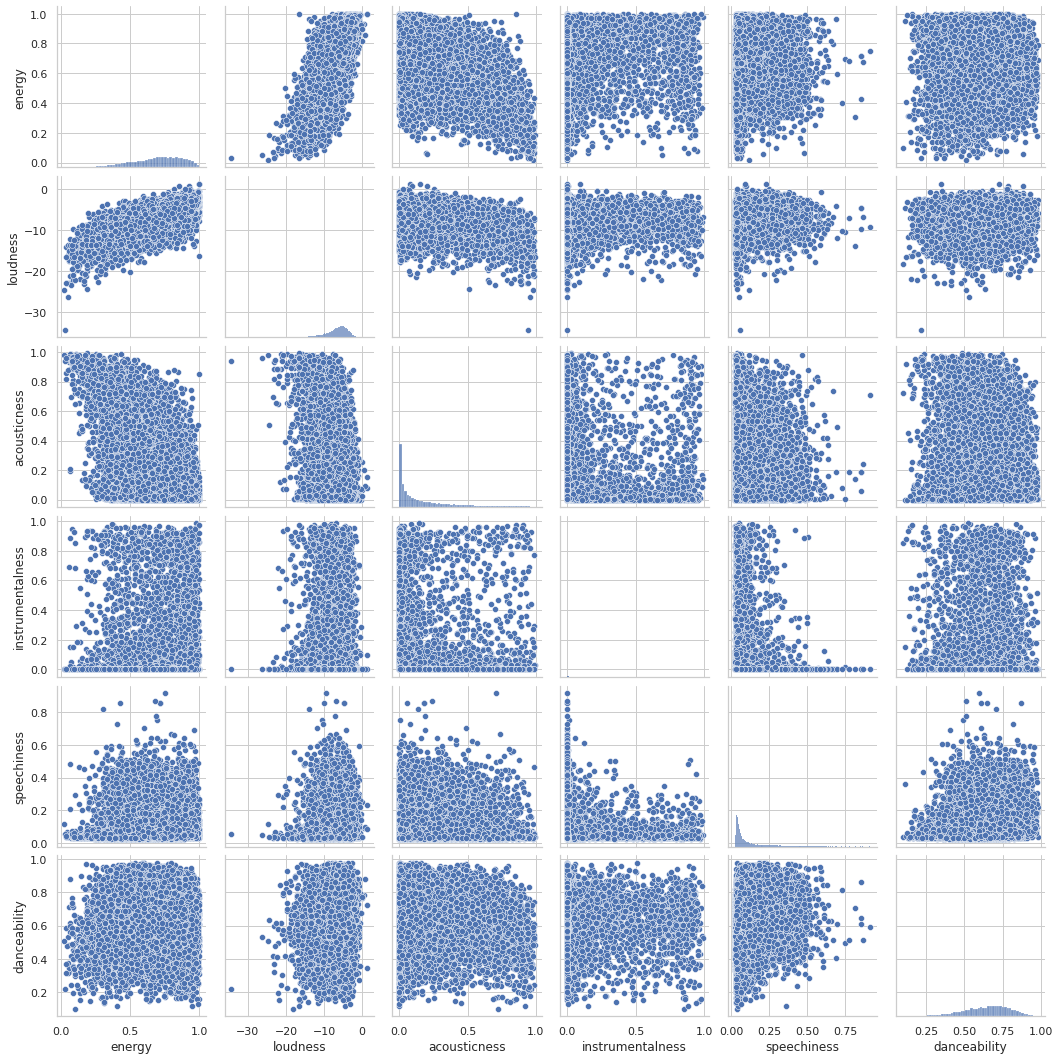

In [ ]:
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")
cols = ["energy","loudness","acousticness","instrumentalness","speechiness","danceability" ]
sns.pairplot(df[cols], height = 2.5 )
plt.show();

